<center><h2>Setup - Environment & Dependencies</center></h2>

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from math import modf

%matplotlib inline

plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.axisbelow'] = True

import warnings
warnings.filterwarnings("ignore")

In [5]:
surface = pd.read_csv('ttc_surface_route_delays.csv')
weather = pd.read_csv('weather.csv')
holidays = pd.read_csv('holidays.csv')

In [6]:
surface['Report Date'] = pd.to_datetime(surface['Report Date'])
surface['Month'] = surface['Report Date'].dt.month
surface['nDay'] = surface['Report Date'].dt.day
surface = surface.rename(columns={'Report Date': 'Date'})
surface = surface.drop(columns=['Unnamed: 0'])

weather['Date/Time'] = pd.to_datetime(weather['Date/Time'])
weather = weather.rename(columns={
    'Date/Time': 'Date', 
    'Mean Temp (°C)': 'Mean Temp', 
    'Total Precip (mm)': 'Precipitation'
})
weather = weather.drop(columns={'Year', 'Month', 'Day'})

holidays = holidays.rename(columns={'date': 'Date', 'holiday': 'Holiday'})
holidays['Date'] = pd.to_datetime(holidays['Date'])

surface = pd.merge(surface, weather, on='Date', how='left')
surface = pd.merge(surface, holidays, on='Date', how='left')

surface['Holiday'] = surface['Holiday'].fillna('None')

surface = surface[surface['Min Delay'] < 7000]
surface['Route'] = surface['Route'].astype('category')
surface['Vehicle'] = surface['Vehicle'].astype('category')

In [5]:
#surface.to_csv('surface_master.csv')

In [7]:
surface.sort_values('Min Delay', ascending=False).head(3)

,Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle,...,nDay,Max Temp (°C),Min Temp (°C),Mean Temp,Total Rain (mm),Total Snow (cm),Precipitation,Snow on Grnd (cm),Spd of Max Gust (km/h),Holiday
214581,2016-07-26,506,5.67,Sunday,Howardpark and Dundas,Diversion,6518.0,6528.0,B/W,7403.0,...,26,29.5,17.6,23.6,0.0,0.0,0.0,0.0,35,None
269609,2015-03-21,32,5.00,Thursday,Eglinton and Richardson,Diversion,5775.0,5783.0,b/w,NaN,...,21,6.3,-4.4,1.0,1.4,0.0,2.9,0.0,57,None
342694,2014-02-21,73,18.37,Wednesday,ALBION & ISLINGTON,Diversion,3780.0,398.0,S,8044.0,...,21,4.6,0.0,2.3,2.0,0.0,5.5,18.8,58,None


In [10]:
surface['Route'].nunique()

448

In [ ]:
holidays.head()

In [ ]:
weather.head()

In [ ]:
surface.info()

In [6]:
surface.sort_values('Min Delay', ascending=False).head(5)

,Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle,...,nDay,Max Temp (°C),Min Temp (°C),Mean Temp,Total Rain (mm),Total Snow (cm),Precipitation,Snow on Grnd (cm),Spd of Max Gust (km/h),Holiday
214581,2016-07-26,506,5.67,Sunday,Howardpark and Dundas,Diversion,6518.0,6528.0,B/W,7403.0,...,26,29.5,17.6,23.6,0.0,0.0,0.0,0.0,35,None
269609,2015-03-21,32,5.00,Thursday,Eglinton and Richardson,Diversion,5775.0,5783.0,b/w,NaN,...,21,6.3,-4.4,1.0,1.4,0.0,2.9,0.0,57,None
342694,2014-02-21,73,18.37,Wednesday,ALBION & ISLINGTON,Diversion,3780.0,398.0,S,8044.0,...,21,4.6,0.0,2.3,2.0,0.0,5.5,18.8,58,None
414903,2014-12-02,73,14.42,Sunday,LAROSE AND SCARLETT RD,Diversion,3380.0,368.0,S,8025.0,...,2,1.7,-9.9,-4.1,0.0,0.7,0.8,0.0,46,None
390748,2014-09-04,172,10.62,Tuesday,Parliament and Front,Diversion,2430.0,2650.0,w,7830.0,...,4,28.7,15.8,22.3,0.0,0.0,0.0,0.0,34,None


<center><h2>Impact of Precipitation on Min Delay by Route</center></h2>

In [11]:
routes = surface.groupby('Route').agg({'Min Delay': 'sum', 'Precipitation': 'sum'}).reset_index()
routes.head()

,Route,Min Delay,Precipitation
0,1,1865.0,476.8
1,2,1341.0,78.9
2,3,344.0,45.3
3,4,381.0,39.9
4,5,40763.0,3172.6


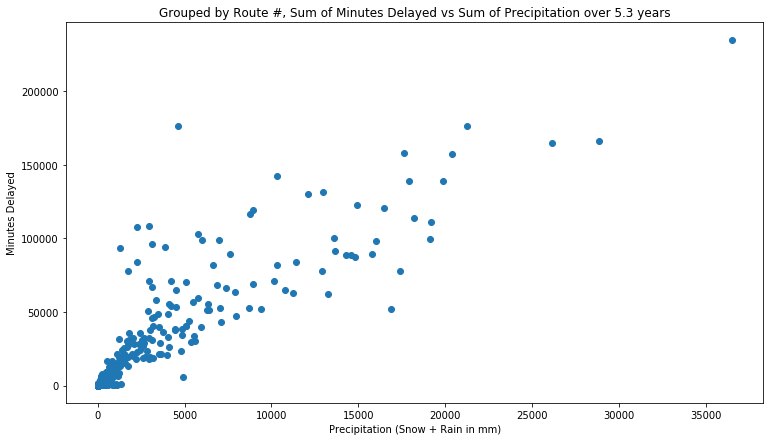

In [8]:
fig, ax = plt.subplots(1, figsize = [12.5, 7])

ax.scatter(routes['Precipitation'], routes['Min Delay'])

ax.set_ylabel('Minutes Delayed')
ax.set_xlabel('Precipitation (Snow + Rain in mm)')
ax.set_title('Grouped by Route #, Sum of Minutes Delayed vs Sum of Precipitation over 5.3 years')

plt.show()

<center><h2>Exploratory Scatterplot</center</h2>

In [ ]:
fig, ax = plt.subplots(1, figsize = [12.5, 7])

ax.scatter(
    surface['Precipitation'], 
    surface['Min Delay'], 
    c=surface['Mean Temp'], 
    alpha = 0.5
)

ax.set_ylabel('Minutes')
ax.set_xlabel('Daily Precipitation')
ax.set_title('Surface Routes - Temperature vs. Minutes Delayed')

plt.text(-30, -2000, 'Note: \
                    \n- Temperature in degrees celsius. \
                    \n- Outlier of 246245 (2014-03-03) minutes delayed removed. \
                    \n- Colored by Mean Temperature per Day')

plt.tight_layout()
plt.savefig('Surface Routes - Temperature vs. Minutes Delayed.png')
plt.show()

In [ ]:
vehicles = surface.groupby(['Date', 'Route', 'Vehicle']).agg({'Min Delay': 'sum', 'Min Gap': 'sum', 'Precipitation': 'sum'})
vehicles = vehicles.rename(columns={'Min Delay': 'Total Minutes', 'Min Gap': 'Total Gap'}).reset_index()
vehicles.head(10)

In [ ]:
vehicles['Total Minutes'].mean(), vehicles['Total Gap'].mean()

In [ ]:
vehicles = vehicles[vehicles['Total Minutes'] < 200]

fig, ax = plt.subplots(1, figsize=[12.5, 7])

ax.hist(vehicles['Total Minutes'], bins = 100)

plt.show()

<center><h2>Delay Time</h2></center>

In [ ]:
groupedbyday = surface.groupby(['Date', 'Day']).agg({'Min Delay': 'sum'})
groupedbyday = groupedbyday.reset_index()
groupedbyday

In [ ]:


fig, ax = plt.subplots(1, figsize = [12.5, 7])

ax.hist(groupedbyday['Min Delay'], bins = 100)

plt.show()

In [ ]:
groupedbyday.mean(), groupedbyday.median()

In [ ]:
totaldays = len(groupedbyday)
totalmin = groupedbyday['Min Delay'].sum()
meanminperday = round(groupedbyday['Min Delay'].mean(), 2)
medianminperday = round(groupedbyday['Min Delay'].median(), 2)
daysdelay = round((groupedbyday['Min Delay'].sum()/60)/24, 2)
percdelay = round((daysdelay / totaldays)/100, 2)
sigmaday = round(groupedbyday['Min Delay'].std(), 2)
delayvariance = round(sigmaday ** 2, 2)

delaystats_dict = {
    'Total Days': totaldays,
    'Total Minutes': daysdelay,
    'Mean Min. per Day': meanminperday,
    'Median Min. per Day': medianminperday,
    '% of Days Delayed': percdelay,
    'Daily Sigma': sigmaday,
    'Delay Variance': delayvariance
}

delaystats = pd.DataFrame(delaystats_dict, index=['Stats'])

delaystats = delaystats.style.format({
    '% of Days Delayed': '{:.2%}'.format
})

In [ ]:
totaldays, totalmin, meanminperday, medianminperday, daysdelay, percdelay, sigmaday, delayvariance

In [ ]:
delaystats

In [ ]:
surface.head()

In [ ]:
incidents = surface.groupby('Incident').agg({'Min Delay': 'sum', 'Min Gap': 'sum'}).sort_values('Min Delay')
incidents = incidents.reset_index()
incidents

In [ ]:
names = incidents['Incident'].unique().tolist()
names

In [ ]:
bar1 = weekdays['Min Delay']
bar2 = weekdays['Min Gap']

label = weekdays['Day']
barwidth = 1
names = weekdays['Day'].unique().tolist()
dayorder = [1, 5, 6, 4, 0, 2, 3]
names = [names[i] for i in dayorder]

In [ ]:
bar1 = incidents['Min Delay']
bar2 = incidents['Min Gap']

label = incidents['Incident']
barwidth = 1

description = incidents['Incident'].unique().tolist()
description_order = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
descriptions = [description[i] for i in description_order]

bars = np.add(bar1, bar2).tolist()

fig, ax = plt.subplots(1, figsize = [12.5, 10])

p1 = ax.bar(label, bar1, color='#800000', edgecolor='white', width=barwidth)
p2 = ax.bar(label, bar2, bottom=bar1, color='#888888', edgecolor='white', width=barwidth)

ax.set_ylabel('Minutes')
ax.set_xlabel('Days of the Week')
ax.set_title('Sum of Minutes per Delay Description')

plt.legend((p1[0], p2[0]), ('Minutes Delayed', 'Gap in Minutes'))

plt.xticks(label, descriptions, rotation = 35)

plt.tight_layout()

plt.savefig('Sum of Minutes per Delay Description.png')
plt.show()

<center><h2>Time of Day</center></h2>

In [17]:
surface.head()

,Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle,...,nDay,Max Temp (°C),Min Temp (°C),Mean Temp,Total Rain (mm),Total Snow (cm),Precipitation,Snow on Grnd (cm),Spd of Max Gust (km/h),Holiday
0,2019-01-03,39,0.22,Tuesday,NECR,Mechanical,9.0,18.0,W/B,1794.0,...,3,1.3,-2.5,-0.6,0.0,0.0,0.0,2.8,44,None
1,2019-01-03,111,0.25,Tuesday,Eglington,Mechanical,15.0,30.0,S/B,8065.0,...,3,1.3,-2.5,-0.6,0.0,0.0,0.0,2.8,44,None
2,2019-01-03,35,0.30,Tuesday,Finch,Mechanical,9.0,18.0,S/B,3275.0,...,3,1.3,-2.5,-0.6,0.0,0.0,0.0,2.8,44,None
3,2019-01-03,25,0.50,Tuesday,Don Mills Rd/Eglinton Ave E,Mechanical,9.0,18.0,N/B,8840.0,...,3,1.3,-2.5,-0.6,0.0,0.0,0.0,2.8,44,None
4,2019-01-03,36,0.67,Tuesday,Humberwood,Investigation,9.0,18.0,E/B,9119.0,...,3,1.3,-2.5,-0.6,0.0,0.0,0.0,2.8,44,None


In [18]:
surface.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 493854 entries, 0 to 494168
Data columns (total 23 columns):
Date                      493854 non-null datetime64[ns]
Route                     493854 non-null category
Time                      493854 non-null float64
Day                       493854 non-null object
Location                  492937 non-null object
Incident                  492923 non-null object
Min Delay                 493854 non-null float64
Min Gap                   493311 non-null float64
Direction                 484585 non-null object
Vehicle                   428506 non-null category
Year                      493854 non-null int64
Type                      493854 non-null object
Month                     493854 non-null int64
nDay                      493854 non-null int64
Max Temp (°C)             493854 non-null float64
Min Temp (°C)             493854 non-null float64
Mean Temp                 493854 non-null float64
Total Rain (mm)           493854 non-null

In [114]:
timeofday = surface.groupby(['Day', 'Time']).agg({'Min Delay': 'sum'}).reset_index()
timeofday = timeofday[timeofday['Time'] < 24]
timeofday['Hour'] = round(((timeofday['Time'] / 1) * 60) / 60, 0)
timeofday.head()

,Day,Time,Min Delay,Hour
0,Friday,0.00,1101.0,0.0
1,Friday,0.02,466.0,0.0
2,Friday,0.03,502.0,0.0
3,Friday,0.05,173.0,0.0
4,Friday,0.07,109.0,0.0


In [147]:
weeklysum = timeofday.groupby(['Day', 'Hour']).agg({'Min Delay': 'sum'}).reset_index().reset_index()
weeklysum = weeklysum.rename(columns={'index': 'Chronological', 'Min Delay': 'Min Sum'})
minmean = timeofday.groupby(['Day', 'Hour']).agg({'Min Delay': 'mean'}).rename(columns={'Min Delay': 'Min Mean'}).reset_index()
weeklysum['Min Mean'] = round(minmean['Min Mean'], 2)
weeklysum.tail()

,Chronological,Day,Hour,Min Sum,Min Mean
170,170,Wednesday,20.0,35505.0,582.05
171,171,Wednesday,21.0,34079.0,577.61
172,172,Wednesday,22.0,25985.0,425.98
173,173,Wednesday,23.0,21556.0,365.36
174,174,Wednesday,24.0,7591.0,253.03


In [148]:
weeklysum['Standard'] = ''

for index, row in weeklysum.iterrows():
    
    if row['Hour'] == 0.0:
    
        row['Standard'] = '12 AM'
    
    elif row['Hour'] == 1.0:
    
        row['Standard'] = '1 AM'
    
    elif row['Hour'] == 2.0:
    
        row['Standard'] = '2 AM'
    
    elif row['Hour'] == 3.0:
    
        row['Standard'] = '3 AM'
    
    elif row['Hour'] == 4.0:
    
        row['Standard'] = '4 AM'
    
    elif row['Hour'] == 5.0:
    
        row['Standard'] = '5 AM'
    
    elif row['Hour'] == 6.0:
    
        row['Standard'] = '6 AM'
        
    else:
        
        row['Standard'] = 'None'

In [149]:
weeklysum.head()

,Chronological,Day,Hour,Min Sum,Min Mean,Standard
0,0,Friday,0.0,10001.0,322.61,
1,1,Friday,1.0,16464.0,279.05,
2,2,Friday,2.0,14413.0,236.28,
3,3,Friday,3.0,7235.0,124.74,
4,4,Friday,4.0,12601.0,206.57,


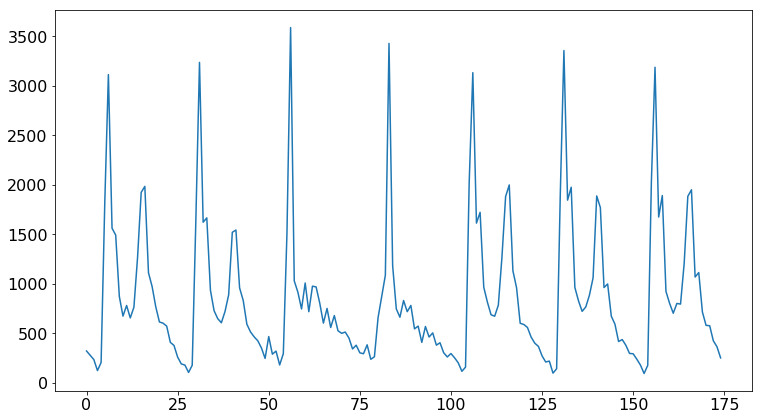

In [139]:
ticks = [12, 36, 60, 84, 106, 130, 154]
labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

fig, ax = plt.subplots(1, figsize = [12.5, 7])

ax.plot(weeklysum['Chronological'], weeklysum['Min Mean'])

#plt.xticks(ticks = ticks, labels = labels)


plt.show()